In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Graph embedding notebook

Evaluate options for graph embeddings

some useful references:

- https://distill.pub/2021/gnn-intro/
- https://web.stanford.edu/class/cs224w/
- https://pytorch-geometric.readthedocs.io/en/latest/

Structure of the nb:

1) data prep
2) model and training
3) visualization

Next steps:

Train/test split, include Argoverse data

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import networkx as nx
import numpy as np
from enum import Enum

import pickle
import networkx as nx
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool, global_add_pool

import torch
import torch.nn.functional as F
import os
import glob
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import glob
import pickle
from tqdm import tqdm
from graph_creator.plot_graphs import plot_lane_map_advanced, add_actors_to_map, add_actor_edges_to_map
from graph_creator.MapGraph import MapGraph
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

from graph_creator.graph_embeddings import GraphDataset, TrainableGraphGINE, contrastive_loss, augment_graph, get_feature_dimensions, networkx_to_pyg

### Data prep

In [8]:
graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/*.pkl")
# graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/*.pkl")
# graph_paths = [path for path in graph_paths if "2025-09-05" in path]
print(len(graph_paths))


14099


In [9]:
# open one graph
with open(graph_paths[0], 'rb') as f:
    graph = pickle.load(f)
#graph.graph.graph
print(graph.nodes(data=True)["583"])
graph.edges(data=True)


{'lane_id': '1_1', 'lane_ids': ['1_1'], 's': 33.50000810623169, 'xyz': <POINT Z (-77.501 2.738 0.021)>, 'lon_speed': 6.361424280807165, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': False, 'is_on_intersection': False}


OutMultiEdgeDataView([('583', '568', {'edge_type': 'following_lead', 'path_length': 43.75999861955643}), ('568', '583', {'edge_type': 'following_lead', 'path_length': 43.75999861955643})])

In [10]:
# add argoverse data
# currently not yet having is_on_intersection, hence not using for the moment
argoverse_graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/*.pkl")
graph_paths.extend(argoverse_graph_paths)
print(len(graph_paths))

# open one argoverse graph

with open(argoverse_graph_paths[0], 'rb') as f:
    graph = pickle.load(f)
#graph.graph.graph
print(graph.nodes(data=True))
graph.edges(data=True)

28825
[('95694', {'lane_id': '411566553', 'lane_ids': ['411566553', '411566837'], 's': 0.8780051626203906, 'xyz': <POINT Z (-7665.091 -385.704 0)>, 'lon_speed': 12.659329978378464, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': True, 'is_on_intersection': True}), ('96899', {'lane_id': '411565909', 'lane_ids': ['411565909'], 's': 10.61887914096711, 'xyz': <POINT Z (-7880.504 -393.296 0)>, 'lon_speed': 9.826591327423547, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': False, 'is_on_intersection': False}), ('96922', {'lane_id': '411634907', 'lane_ids': ['411634907'], 's': 5.446817085723614, 'xyz': <POINT Z (-7738.516 -362.65 0)>, 'lon_speed': 4.950740637682559, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': False, 'is_on_intersection': False}), ('96927', {'lane_id': '411566598', 'lane_ids': ['411566598'], 's': 24.273106005944108, 'xyz': <POINT Z (-7826.397 -393.288 0)>, 'lon_speed': 12.33114435108836, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, '

OutMultiEdgeDataView([('95694', '96948', {'edge_type': 'neighbor_vehicle', 'path_length': 23.796058070189225}), ('95694', '97274', {'edge_type': 'opposite_vehicle', 'path_length': 19.461143125667906}), ('96899', '97304', {'edge_type': 'following_lead', 'path_length': 14.86274126794251}), ('96899', '97356', {'edge_type': 'neighbor_vehicle', 'path_length': -5.344298214521521}), ('96922', '97330', {'edge_type': 'following_lead', 'path_length': 7.798389191146189}), ('96922', '97343', {'edge_type': 'following_lead', 'path_length': 10.237841152677563}), ('96927', '96945', {'edge_type': 'following_lead', 'path_length': 48.34003959121122}), ('96927', '97356', {'edge_type': 'following_lead', 'path_length': 48.72034039225175}), ('96940', '96945', {'edge_type': 'following_lead', 'path_length': 44.84269561124645}), ('96940', '96948', {'edge_type': 'following_lead', 'path_length': 45.11731754576551}), ('96945', '96940', {'edge_type': 'following_lead', 'path_length': 44.84269561124645}), ('96945', '

In [11]:
# Load data
graph_ds = GraphDataset(graph_paths)
#train_loader = DataLoader(graph_ds, batch_size=128, shuffle=True)

In [12]:
type(graph_ds)

graph_creator.graph_embeddings.GraphDataset

In [13]:
# Train/test split for graph_ds
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

indices = np.arange(len(graph_ds))
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=True
)

train_ds = Subset(graph_ds, train_idx)
test_ds = Subset(graph_ds, test_idx)

# Create loaders (overrides earlier train_loader)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

print(f"Train size: {len(train_ds)} | Test size: {len(test_ds)}")
data_loaders = {"train": train_loader, "test": test_loader}

Train size: 23060 | Test size: 5765


/home/tmuehlen/.cache/pypoetry/virtualenvs/graph-creator-_1ofKhL9-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [14]:
# set([path.split("/")[-1].split("_")[1] for path in graph_paths])

In [15]:
# try out data loader
graph_ds.__getitem__(4320)

#batch = next(iter(train_loader))

(Data(x=[11, 7], edge_index=[2, 32], edge_attr=[32, 7]),
 '/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_2025-10-05 21:28:36.127587_Town05_0_5.pkl')

### Training

In [16]:
# Model setup
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
node_dim, edge_dim = get_feature_dimensions()
model = TrainableGraphGINE(node_dim, edge_dim, 256, 96, 4).to(device)



In [17]:
node_dim

7

In [18]:
# get the pre-training loss
from typing import Any


total_losses = {"train": [], "test": [], "lr": [0.02]}

for split in data_loaders:
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(data_loaders[split]):
            batch = batch[0].to(device)
            aug_batch = augment_graph(batch).to(device)
            outputs1 = model(batch)
            outputs2 = model(aug_batch)
            loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
            total_loss += loss.item()
    total_losses[split].append( total_loss / len(data_loaders[split]))

print(total_losses)

100%|██████████| 46/46 [01:25<00:00,  1.85s/it]

{'train': [3.781276428897078], 'test': [3.7333079356214274], 'lr': [0.02]}


In [19]:
# Training
# hm, too lazy to do a proper learning rate schedule
for i in range(2):
    lr = 0.02*0.75**i
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"loop {i}, Learning rate: {lr}")
    for epoch in range(2):
        total_loss = 0
    
        for batch in train_loader:
            batch = batch[0].to(device)
            aug_batch = augment_graph(batch).to(device)

            optimizer.zero_grad()

            outputs1 = model(batch)
            outputs2 = model(aug_batch)

            loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # if epoch % 1 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}')

        total_losses["lr"].append(lr)
        for split in data_loaders:
            total_loss = 0
            with torch.no_grad():
                for batch in data_loaders[split]:
                    batch = batch[0].to(device)
                    aug_batch = augment_graph(batch).to(device)
                    outputs1 = model(batch)
                    outputs2 = model(aug_batch)
                    loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
                    total_loss += loss.item()
            total_losses[split].append( total_loss / len(data_loaders[split]))



loop 0, Learning rate: 0.02
Epoch 0, Loss: 2.0458
Epoch 1, Loss: 1.0274
loop 1, Learning rate: 0.015
Epoch 0, Loss: 0.7135
Epoch 1, Loss: 0.5900


In [20]:
os.getcwd()


'/home/tmuehlen/repos/graph_coverage/Notebooks/carla'

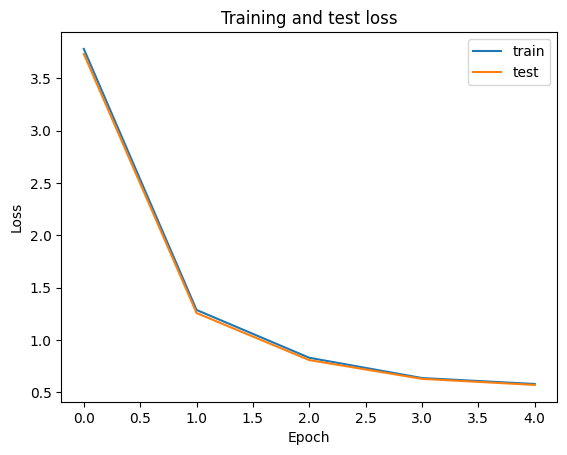

In [21]:
plt.plot(total_losses["train"], label = "train")
plt.plot(total_losses["test"], label = "test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.title("Training and test loss")
# plt.savefig("/home/tmuehlen/repos/graph_coverage/article/plots/train_test_graph_embeddings_loss_plot.png")
plt.show()


### High-level model architecture (Mermaid)

The following cell generates a paper-friendly Mermaid diagram of the GINE architecture (layers, pooling, embedding MLP, projection head), saves it to `figures/graph_gine_architecture.mmd`, and attempts to render SVG/PDF if `mmdc` is available.


In [22]:
# # Generate Mermaid diagram for the model architecture and save as .mmd (and SVG/PDF if possible)
# import os
# import subprocess

# # Introspect model parameters
# num_layers = getattr(model, 'num_layers', 3)
# embedding_dim = getattr(model, 'embedding_dim', 128)
# # Hidden dim isn't stored directly; infer from first conv MLP out features
# try:
#     hidden_dim = model.convs[0].nn[0].out_features
# except Exception:
#     hidden_dim = 96

# # Feature dims from earlier
# node_dim = node_dim
# edge_dim = edge_dim

# mermaid_lines = []
# mermaid_lines.append("flowchart LR")
# mermaid_lines.append("  subgraph Inputs")
# mermaid_lines.append(f"    X[\"x: R[N,{node_dim}]\"]")
# mermaid_lines.append(f"    EI[\"edge_index: R[2,E]\"]")
# mermaid_lines.append(f"    EA[\"edge_attr: R[E,{edge_dim}]\"]")
# mermaid_lines.append("    B[\"batch: R[N]\"]")
# mermaid_lines.append("  end")

# # GINE layers block
# mermaid_lines.append("  subgraph GINE_Stack")
# for i in range(num_layers):
#     mermaid_lines.append(f"    G{i}[\"GINEConv + BN + ReLU + Dropout (hidden={hidden_dim})\"]")
# mermaid_lines.append("  end")

# # Pooling block
# mermaid_lines.append("  subgraph Pooling")
# mermaid_lines.append("    POOL_MEAN[global_mean_pool]")
# mermaid_lines.append("    POOL_MAX[global_max_pool]")
# mermaid_lines.append("    POOL_SUM[global_add_pool]")
# mermaid_lines.append("  end")

# # Embedding projection
# mermaid_lines.append("  subgraph Embedding")
# mermaid_lines.append(f"    E1[\"Linear 3*hidden to {embedding_dim}; ReLU; Dropout\"]")
# mermaid_lines.append(f"    E2[\"Linear {embedding_dim} to {embedding_dim}\"]")
# mermaid_lines.append("  end")

# # Projection head
# mermaid_lines.append("  subgraph ProjectionHead")
# mermaid_lines.append(f"    P1[\"Linear {embedding_dim} to {embedding_dim}; ReLU\"]")
# mermaid_lines.append(f"    P2[\"Linear {embedding_dim} to {embedding_dim//2}\"]")
# mermaid_lines.append("  end")

# # Edges (no labels to avoid parser issues)
# mermaid_lines.append("  X --> G0")
# mermaid_lines.append("  EI --> G0")
# mermaid_lines.append("  EA --> G0")
# mermaid_lines.append("  B --> G0")
# for i in range(num_layers-1):
#     mermaid_lines.append(f"  G{i} --> G{i+1}")
# mermaid_lines.append("  G"+str(num_layers-1)+" --> POOL_MEAN")
# mermaid_lines.append("  G"+str(num_layers-1)+" --> POOL_MAX")
# mermaid_lines.append("  G"+str(num_layers-1)+" --> POOL_SUM")
# mermaid_lines.append("  POOL_MEAN --> E1")
# mermaid_lines.append("  POOL_MAX --> E1")
# mermaid_lines.append("  POOL_SUM --> E1")
# mermaid_lines.append("  E1 --> E2")
# mermaid_lines.append("  E2 --> P1")
# mermaid_lines.append("  P1 --> P2")

# mermaid_str = "\n".join(mermaid_lines)

# # Save to figures directory
# fig_dir = "/home/tmuehlen/repos/graph_coverage/article/plots/"
# os.makedirs(fig_dir, exist_ok=True)
# mmd_path = os.path.join(fig_dir, "graph_gine_architecture.mmd")
# with open(mmd_path, "w") as f:
#     f.write(mermaid_str)
# print(f"Mermaid source written to: {mmd_path}")

# # Optional: render to SVG/PDF if Mermaid CLI is available
# svg_path = os.path.join(fig_dir, "graph_gine_architecture.svg")
# pdf_path = os.path.join(fig_dir, "graph_gine_architecture.pdf")
# try:
#     result = subprocess.run(["which", "mmdc"], capture_output=True, text=True)
#     if result.returncode == 0:
#         subprocess.check_call(["mmdc", "-i", mmd_path, "-o", svg_path])
#         print(f"SVG written to: {svg_path}")
#         try:
#            subprocess.check_call(["mmdc", "-i", mmd_path, "-o", pdf_path])
#            print(f"PDF written to: {pdf_path}")
#         except Exception:
#            pass
#     else:
#         print("Mermaid CLI (mmdc) not found; install with: npm i -g @mermaid-js/mermaid-cli")
# except Exception as e:
#     print(f"Mermaid rendering skipped: {e}")

# print("\n--- Mermaid diagram ---\n")
# print(mermaid_str)


### Inference

In [23]:
# Inference loop
model.eval()
#all_embeddings_train = []
#all_paths_train = []
all_embeddings = {"train": [], "test": []}
all_paths = {"train": [], "test": []}


for split in data_loaders:  
    with torch.no_grad():
        for batch in tqdm(data_loaders[split]):  # or test_loader
            all_paths[split].extend(batch[1]) 
            batch = batch[0].to(device)
            outputs = model(batch)
            embeddings = outputs['embeddings']
            all_embeddings[split].append(embeddings.cpu())

# Concatenate all embeddings
final_embeddings = {}
for split in all_embeddings:
    final_embeddings[split] = torch.cat(all_embeddings[split], dim=0)

print(f'Extracted {final_embeddings["train"].shape[0]} embeddings of dimension {final_embeddings["train"].shape[1]}')

100%|██████████| 46/46 [00:03<00:00, 14.87it/s]


Extracted 23060 embeddings of dimension 256


In [24]:
graph_dates_train = [path.split("/")[-1].split("_")[1] for path in all_paths["train"]]
graph_dates_test = [path.split("/")[-1].split("_")[1] for path in all_paths["test"]]
#all_paths
graph_dates = {"train": graph_dates_train, "test": graph_dates_test}

In [25]:
graph_type_train = [path.split("/")[6] for path in all_paths["train"]]
graph_type_test = [path.split("/")[6] for path in all_paths["test"]]
graph_type = {"train": graph_type_train, "test": graph_type_test}

### Visualization of embeddings

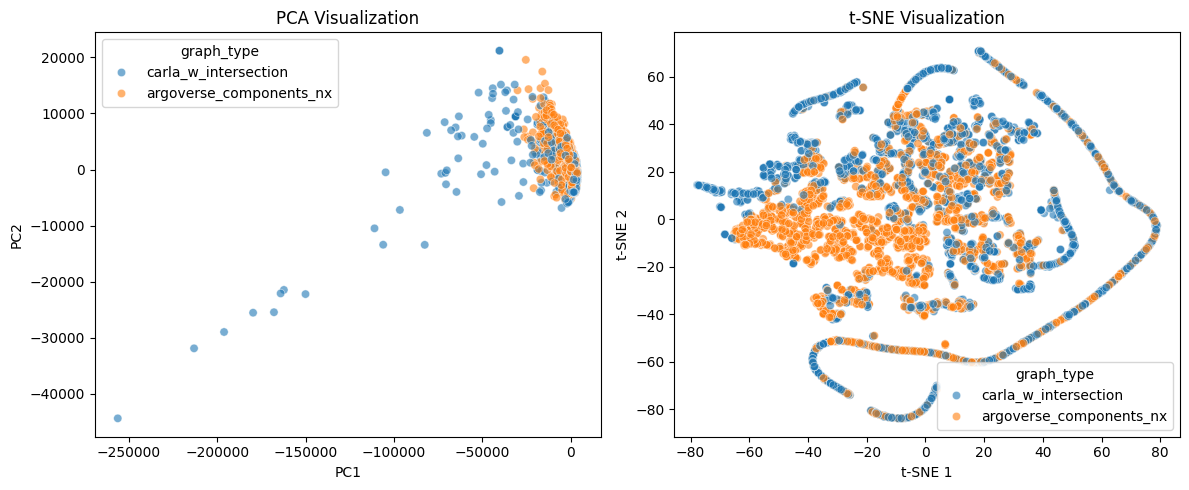

In [26]:
# Convert embeddings to numpy
split = "test"
embeddings_np = final_embeddings[split].numpy()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

pca_df = pd.DataFrame(pca_result)
pca_df.columns = ["pca1", "pca2"]
pca_df["graph_type"] = graph_type[split]
pca_df["graph_path"] = all_paths[split]
pca_df.head()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x="pca1", y="pca2", alpha=0.6, hue="graph_type", legend = True, data=pca_df)
#plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title('PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings_np)
tsne_df = pd.DataFrame(tsne_result)
tsne_df.columns = ["tsne1", "tsne2"]
tsne_df["graph_type"] = graph_type[split]
tsne_df["graph_path"] = all_paths[split]

plt.subplot(1, 2, 2)
# plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6)
sns.scatterplot(x="tsne1", y="tsne2", alpha=0.6, hue="graph_type", legend = True, data=tsne_df)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
#plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_pca_tsne_{split}_plot.png")
plt.show()

In [27]:
### Interactive Plotly visualization with lasso selection


In [28]:
import plotly.graph_objects as go
from IPython.display import display, HTML

# Create FigureWidget for interactive updates
fig_widget = go.FigureWidget()

# Add PCA scatter
fig_widget.add_scatter(
    x=pca_df['pca1'],
    y=pca_df['pca2'],
    mode='markers',
    marker=dict(
        size=6,
        color=pca_df['graph_type'].map({'carla_w_intersection': 0, 'argoverse_nx': 1}),
        colorscale='Viridis',
    ),
    text=pca_df['graph_type'],
    hovertemplate='<b>Type:</b> %{text}<br><b>Index:</b> %{customdata}<br><b>PCA1:</b> %{x:.2f}<br><b>PCA2:</b> %{y:.2f}<extra></extra>',
    customdata=pca_df.index,
    name='Graph Embeddings'
)

fig_widget.update_layout(
    title='Interactive PCA Plot - Select points to extract data',
    xaxis_title='PC1',
    yaxis_title='PC2',
    height=600,
    width=900,
    dragmode='lasso',
    hovermode='closest'
)

# Store selected data globally
selected_df = pd.DataFrame()

def selection_fn(trace, points, selector):
    """Callback function when points are selected"""
    global selected_df
    if len(points.point_inds) > 0:
        selected_indices = [pca_df.index[i] for i in points.point_inds]
        selected_df = pca_df.loc[selected_indices].copy()
        print(f"\n✓ Selected {len(selected_df)} points")
        print(f"Graph types: {selected_df['graph_type'].value_counts().to_dict()}")
        print(f"\nAccess selected data via: selected_df")
        display(selected_df.head())
    else:
        print("No points selected")

# Attach callback
fig_widget.data[0].on_selection(selection_fn)

# Display the widget
display(HTML("<h3>Use lasso or box select tool to select points</h3>"))
fig_widget


FigureWidget({
    'data': [{'customdata': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'Z7FnwWfRZ+Fn8WgBaBFoIWgxaEFg=='),
                             'dtype': 'i2'},
              'hovertemplate': ('<b>Type:</b> %{text}<br><b>Ind' ... '2:</b> %{y:.2f}<extra></extra>'),
              'marker': {'color': {'bdata': ('AAAAAAAAAAAAAAAAAAD4fwAAAAAAAA' ... 'AAAPh/AAAAAAAA+H8AAAAAAAAAAA=='),
                                   'dtype': 'f8'},
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        

In [29]:
# Interactive t-SNE plot
fig_widget_tsne = go.FigureWidget()

# Add t-SNE scatter
fig_widget_tsne.add_scatter(
    x=tsne_df['tsne1'],
    y=tsne_df['tsne2'],
    mode='markers',
    marker=dict(
        size=6,
        color=tsne_df['graph_type'].map({'carla_w_intersection': 0, 'argoverse_nx': 1}),
        colorscale='Viridis',
    ),
    text=tsne_df['graph_type'],
    hovertemplate='<b>Type:</b> %{text}<br><b>Index:</b> %{customdata}<br><b>t-SNE1:</b> %{x:.2f}<br><b>t-SNE2:</b> %{y:.2f}<extra></extra>',
    customdata=tsne_df.index,
    name='Graph Embeddings'
)

fig_widget_tsne.update_layout(
    title='Interactive t-SNE Plot - Select points to extract data',
    xaxis_title='t-SNE 1',
    yaxis_title='t-SNE 2',
    height=600,
    width=900,
    dragmode='lasso',
    hovermode='closest'
)

# Store selected data globally
selected_tsne_df = pd.DataFrame()

def selection_fn_tsne(trace, points, selector):
    """Callback function when points are selected"""
    global selected_tsne_df
    if len(points.point_inds) > 0:
        selected_indices = [tsne_df.index[i] for i in points.point_inds]
        selected_tsne_df = tsne_df.loc[selected_indices].copy()
        print(f"\n✓ Selected {len(selected_tsne_df)} points")
        print(f"Graph types: {selected_tsne_df['graph_type'].value_counts().to_dict()}")
        print(f"\nAccess selected data via: selected_tsne_df")
        display(selected_tsne_df.head())
    else:
        print("No points selected")

# Attach callback
fig_widget_tsne.data[0].on_selection(selection_fn_tsne)

# Display the widget
display(HTML("<h3>Use lasso or box select tool to select points</h3>"))
fig_widget_tsne


FigureWidget({
    'data': [{'customdata': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'Z7FnwWfRZ+Fn8WgBaBFoIWgxaEFg=='),
                             'dtype': 'i2'},
              'hovertemplate': ('<b>Type:</b> %{text}<br><b>Ind' ... '2:</b> %{y:.2f}<extra></extra>'),
              'marker': {'color': {'bdata': ('AAAAAAAAAAAAAAAAAAD4fwAAAAAAAA' ... 'AAAPh/AAAAAAAA+H8AAAAAAAAAAA=='),
                                   'dtype': 'f8'},
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        

tsne1     tsne2               graph_type  \
547   5.164646  8.071838     carla_w_intersection   
592   4.876693  7.486704  argoverse_components_nx   
825   4.755862  7.518551  argoverse_components_nx   
854   7.029703  7.403428     carla_w_intersection   
1221  6.599467  9.105330  argoverse_components_nx   

                                             graph_path  
547   /home/tmuehlen/repos/graph_coverage/actor_grap...  
592   /home/tmuehlen/repos/graph_coverage/actor_grap...  
825   /home/tmuehlen/repos/graph_coverage/actor_grap...  
854   /home/tmuehlen/repos/graph_coverage/actor_grap...  
1221  /home/tmuehlen/repos/graph_coverage/actor_grap...

In [37]:
selected_tsne_df

tsne1     tsne2               graph_type  \
547   5.164646  8.071838     carla_w_intersection   
592   4.876693  7.486704  argoverse_components_nx   
825   4.755862  7.518551  argoverse_components_nx   
854   7.029703  7.403428     carla_w_intersection   
1221  6.599467  9.105330  argoverse_components_nx   
1614  5.332073  8.067206     carla_w_intersection   
2110  6.901522  7.496724     carla_w_intersection   
2592  6.769375  9.422506     carla_w_intersection   
2780  6.015932  8.720305  argoverse_components_nx   
3863  6.869198  7.267053     carla_w_intersection   
4364  5.833895  7.858302  argoverse_components_nx   

                                             graph_path  
547   /home/tmuehlen/repos/graph_coverage/actor_grap...  
592   /home/tmuehlen/repos/graph_coverage/actor_grap...  
825   /home/tmuehlen/repos/graph_coverage/actor_grap...  
854   /home/tmuehlen/repos/graph_coverage/actor_grap...  
1221  /home/tmuehlen/repos/graph_coverage/actor_grap...  
1614  /home/tmuehlen/repos/graph_coverage/actor_grap...  
2110  /home/tmuehlen/repos/graph_coverage/actor_grap...  
2592  /home/tmuehlen/repos/graph_coverage/actor_grap...  
2780  /home/tmuehlen/repos/graph_coverage/actor_grap...  
3863  /home/tmuehlen/repos/graph_coverage/actor_grap...  
4364  /home/tmuehlen/repos/graph_coverage/actor_grap...

In [38]:
# Helper function to get full embeddings for selected points
def get_embeddings_for_selection(selected_dataframe, split="test"):
    """
    Get the full 256-dimensional embeddings for selected points
    
    Parameters:
    -----------
    selected_dataframe : pd.DataFrame
        The dataframe of selected points (selected_df or selected_tsne_df)
    split : str
        'train' or 'test' split
    
    Returns:
    --------
    np.ndarray : Array of embeddings for selected points
    """
    if len(selected_dataframe) == 0:
        print("No points selected")
        return None
    
    # Get indices in the original embeddings array
    # The dataframe index corresponds to the position in the test/train set
    indices = selected_dataframe.index.tolist()
    
    # Extract embeddings
    embeddings_np = final_embeddings[split].numpy()
    selected_embeddings = embeddings_np[indices]
    
    print(f"Retrieved {selected_embeddings.shape[0]} embeddings of dimension {selected_embeddings.shape[1]}")
    return selected_embeddings

# Example usage (after selecting points):
selected_embeddings = get_embeddings_for_selection(selected_tsne_df, split="test")
# Or for graph paths:
# selected_paths = selected_df['graph_path'].tolist()
print("After selecting points, use:")
print("  - selected_df or selected_tsne_df to access the selected data")
print("  - get_embeddings_for_selection(selected_df) to get full 256-dim embeddings")
print("  - selected_df['graph_path'].tolist() to get file paths")


Retrieved 11 embeddings of dimension 256
After selecting points, use:
  - selected_df or selected_tsne_df to access the selected data
  - get_embeddings_for_selection(selected_df) to get full 256-dim embeddings
  - selected_df['graph_path'].tolist() to get file paths


In [39]:
selected_tsne_df

tsne1     tsne2               graph_type  \
547   5.164646  8.071838     carla_w_intersection   
592   4.876693  7.486704  argoverse_components_nx   
825   4.755862  7.518551  argoverse_components_nx   
854   7.029703  7.403428     carla_w_intersection   
1221  6.599467  9.105330  argoverse_components_nx   
1614  5.332073  8.067206     carla_w_intersection   
2110  6.901522  7.496724     carla_w_intersection   
2592  6.769375  9.422506     carla_w_intersection   
2780  6.015932  8.720305  argoverse_components_nx   
3863  6.869198  7.267053     carla_w_intersection   
4364  5.833895  7.858302  argoverse_components_nx   

                                             graph_path  
547   /home/tmuehlen/repos/graph_coverage/actor_grap...  
592   /home/tmuehlen/repos/graph_coverage/actor_grap...  
825   /home/tmuehlen/repos/graph_coverage/actor_grap...  
854   /home/tmuehlen/repos/graph_coverage/actor_grap...  
1221  /home/tmuehlen/repos/graph_coverage/actor_grap...  
1614  /home/tmuehlen/repos/graph_coverage/actor_grap...  
2110  /home/tmuehlen/repos/graph_coverage/actor_grap...  
2592  /home/tmuehlen/repos/graph_coverage/actor_grap...  
2780  /home/tmuehlen/repos/graph_coverage/actor_grap...  
3863  /home/tmuehlen/repos/graph_coverage/actor_grap...  
4364  /home/tmuehlen/repos/graph_coverage/actor_grap...

In [40]:
os.getcwd()
os.chdir("../..")
os.getcwd()

'/home/tmuehlen'

In [41]:
pca_emb_df = pd.concat([pca_df, pd.DataFrame(embeddings_np)], axis = 1)
pca_emb_df.head(2)

pca1         pca2               graph_type  \
0  3546.683105 -1399.128052     carla_w_intersection   
1   582.740723 -4041.421875  argoverse_components_nx   

                                          graph_path           0           1  \
0  /home/tmuehlen/repos/graph_coverage/actor_grap...   12.306996   89.424774   
1  /home/tmuehlen/repos/graph_coverage/actor_grap...  220.633514  533.589355   

            2           3           4           5  ...         246  \
0  -26.116398  -24.810059  -71.837723   73.060013  ...  -22.385508   
1 -114.810928 -445.664642 -303.960388 -142.418304  ... -284.537354   

          247         248        249        250         251        252  \
0  108.860474    1.164472 -69.482918  25.686552    2.747611   4.277904   
1 -192.330795  127.774567  86.863052  -8.184095  166.220215 -69.234703   

          253         254         255  
0 -126.525055   68.506775  -37.767017  
1   -4.584624  296.885284 -150.600403  

[2 rows x 260 columns]

In [42]:
mask_carla = pca_df.graph_type == "carla_w_intersection"
mask_argo = pca_df.graph_type == "argoverse_components_nx"
pca_carla_df = pca_df[mask_carla].reset_index(drop=True)
pca_argo_df = pca_df[mask_argo].reset_index(drop=True)


In [43]:
print(sum(mask_carla), sum(mask_argo))
pca_carla_df.head(2)


2849 2916


pca1         pca2            graph_type  \
0  3546.683105 -1399.128052  carla_w_intersection   
1  3312.236816  -812.808899  carla_w_intersection   

                                          graph_path  
0  /home/tmuehlen/repos/graph_coverage/actor_grap...  
1  /home/tmuehlen/repos/graph_coverage/actor_grap...

# visualizing examples from one cluster selection

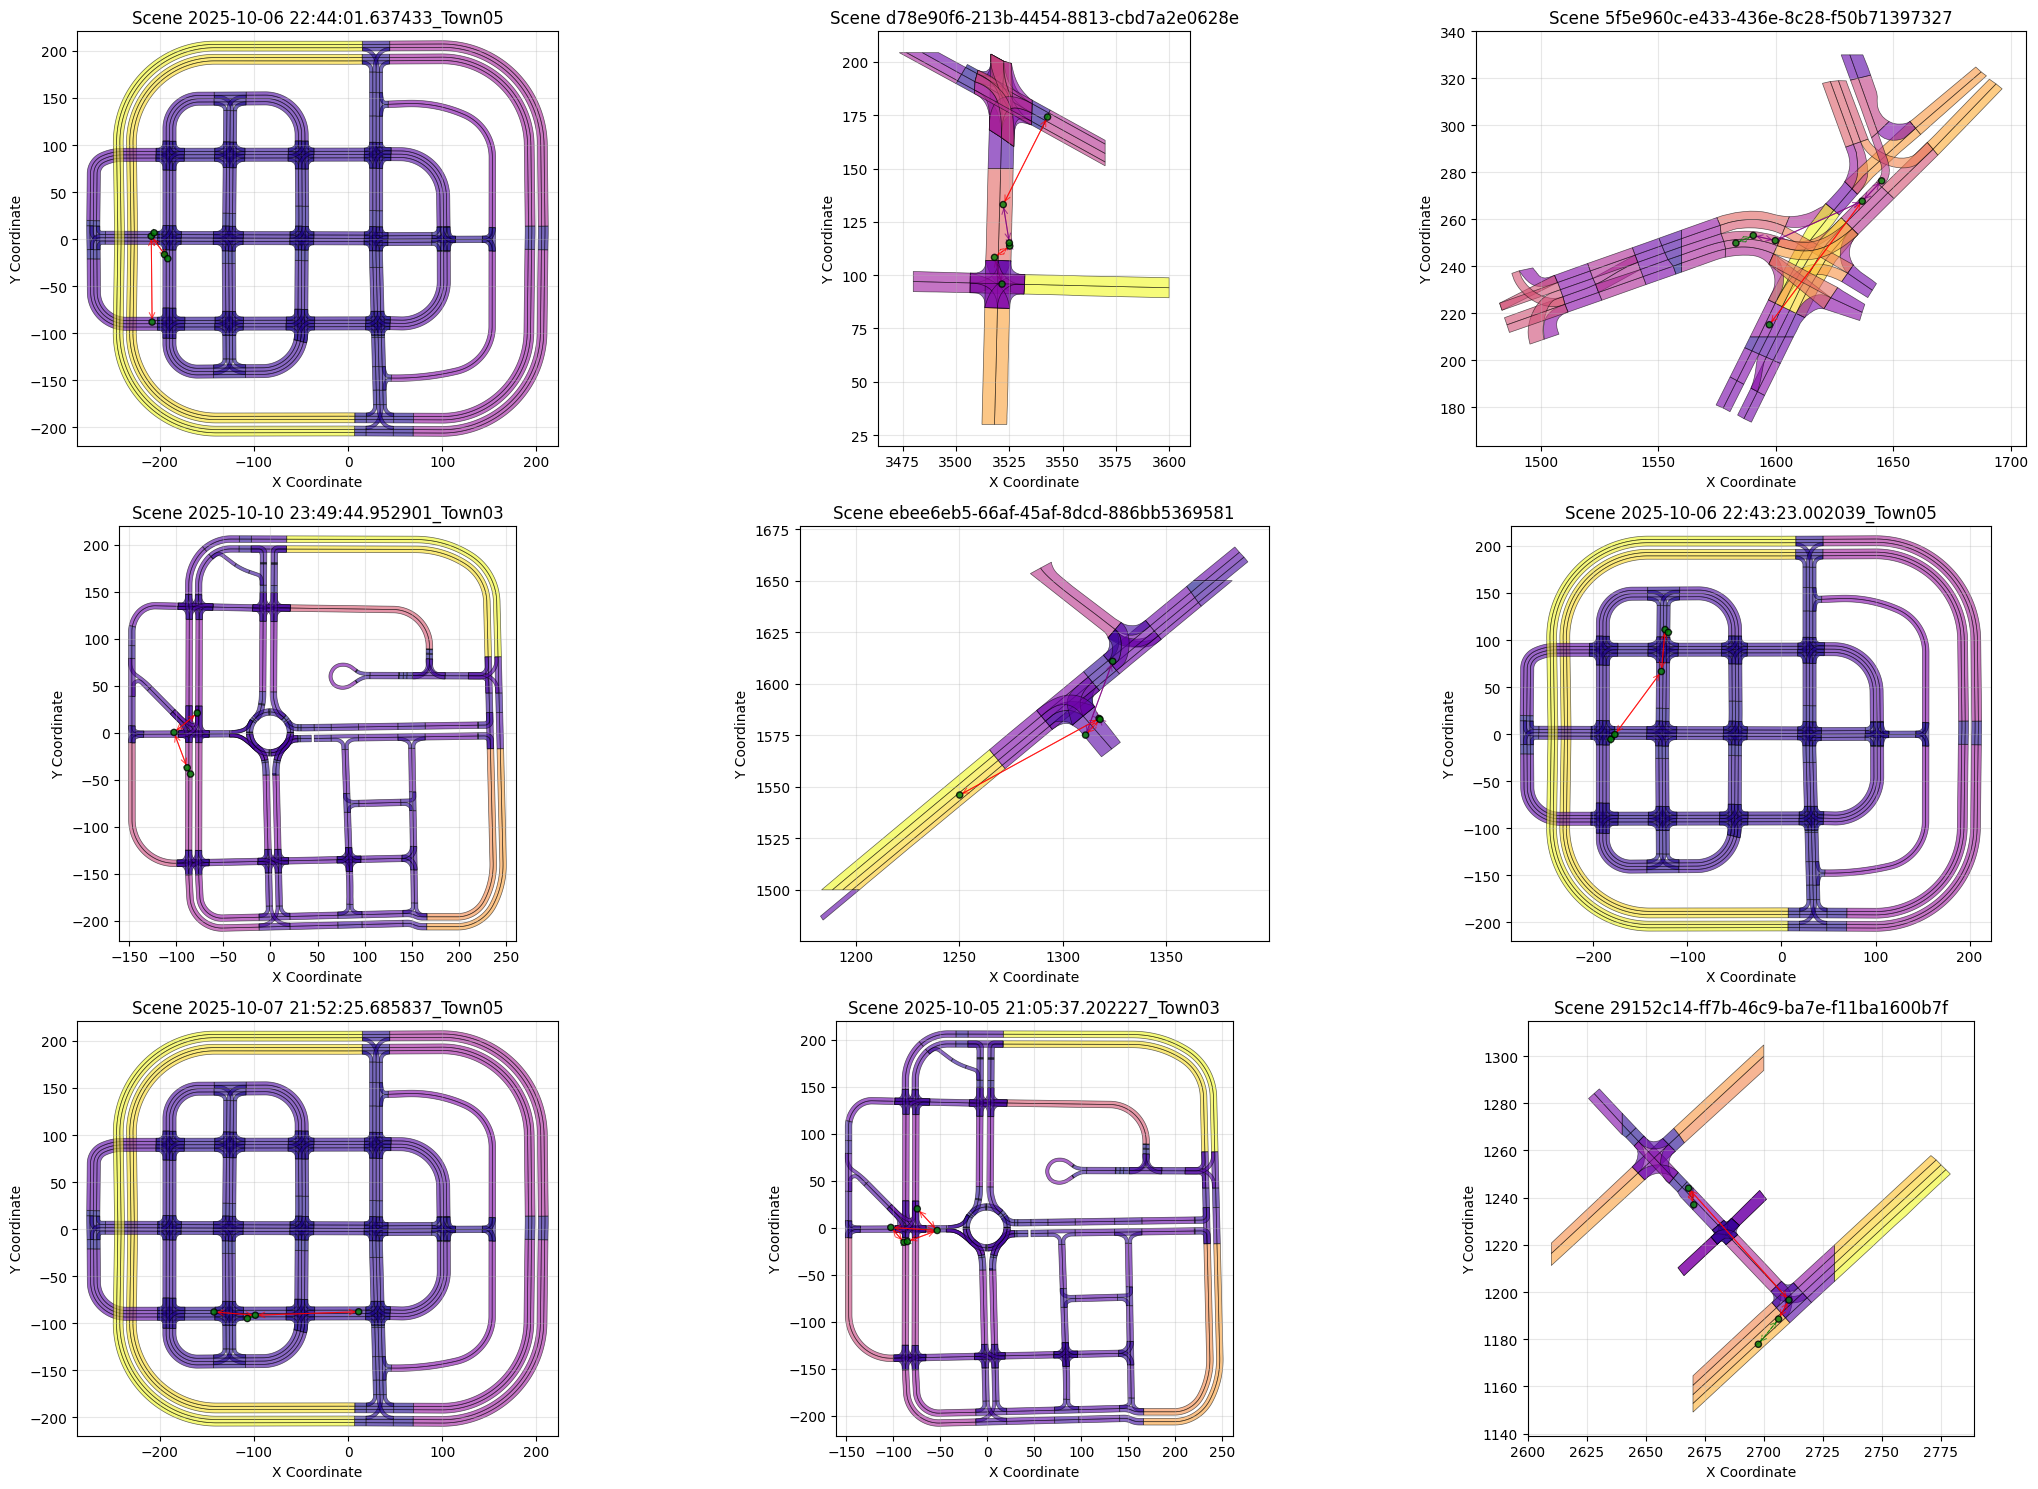

In [46]:
# visualizing examples from one cluster selection
selected_tsne_df.sample(10)
fig, axes = plt.subplots(3, 3, figsize=(30, 15))
axes = axes.flatten()  # Flatten to easily index with loop counter

for i in range(9):
    if selected_tsne_df.graph_type.iloc[i] == "carla_w_intersection":
        graph = selected_tsne_df.graph_path.iloc[i].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        #scn_1 = graph_1[:26]
        scn = "_".join(graph.split("_")[:2])
        file_path = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_{graph}.pkl"
        with open(file_path, 'rb') as f:
            nx_graph = pickle.load(f)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn}_map_graph.pickle')
        g_map = g_map.graph
    else:
        # argoverse option
        graph = selected_tsne_df.graph_path.iloc[i].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn = graph[:36]
        file_path = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/graph_{graph}.pkl"
        with open(file_path, 'rb') as f:
            nx_graph = pickle.load(f)
        g_map = MapGraph()
        # "/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/000ace8b-a3d2-4228-bd87-91b66a9c5127_map_graph.pkl"
        # g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_1}_map_graph.pkl')
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse/{scn}_map_graph.pkl')
        g_map = g_map.graph.graph
        # # Create figure with two subplots side by side
    # First scene (left subplot)
    # # First scene (left subplot)
    ax = axes[i]
    #fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig, ax = plot_lane_map_advanced(g_map, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax)
    fig, ax = add_actors_to_map(fig, ax, nx_graph, actor_size=20, show_actor_labels=False)
    fig, ax = add_actor_edges_to_map(fig, ax, nx_graph)
    ax.set_title(f'Scene {scn}')
# # Adjust layout and display
plt.tight_layout()
# plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_cluster_examples.png")
plt.show()

### Comparing closest embeddings:

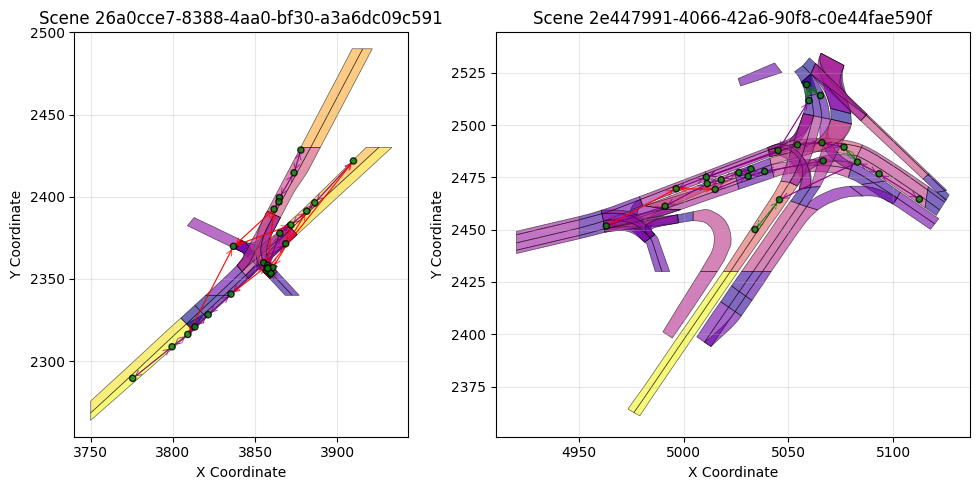

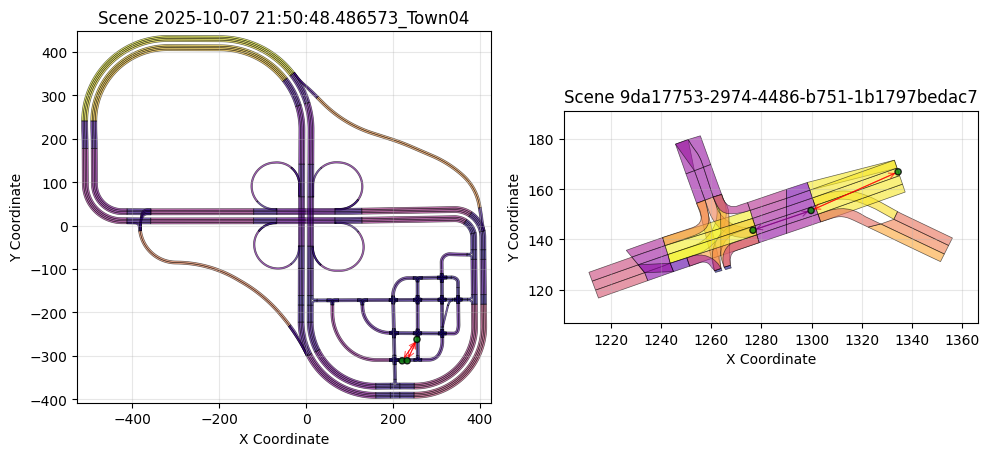

Error processing scene 2025-10-10 23:37:21.631263_Town04 and 2025-10-05 20:57:17.716974_Town01: [Errno 2] No such file or directory: '/home/tmuehlen/repos/graph_coverage/carla/data/scene_2025-10-05 20:57:17.716974_Town01_map_graph.pickle'


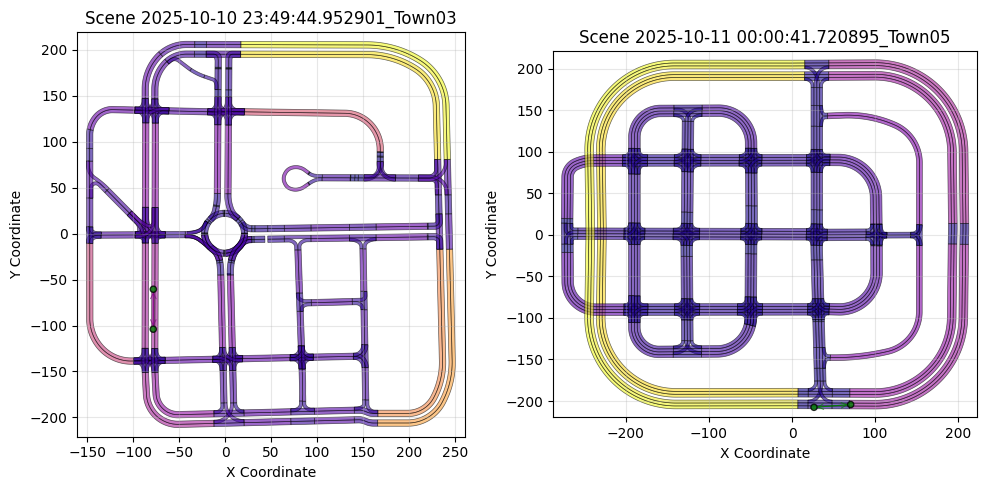

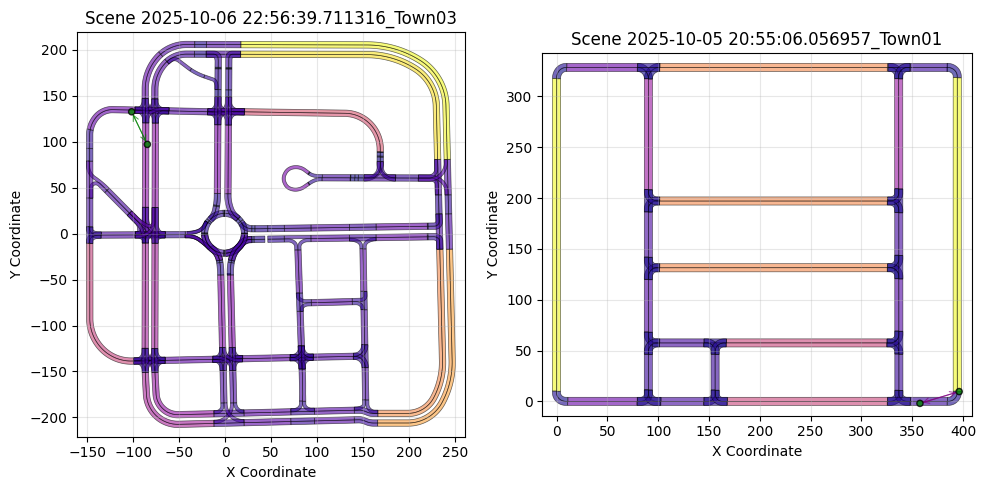

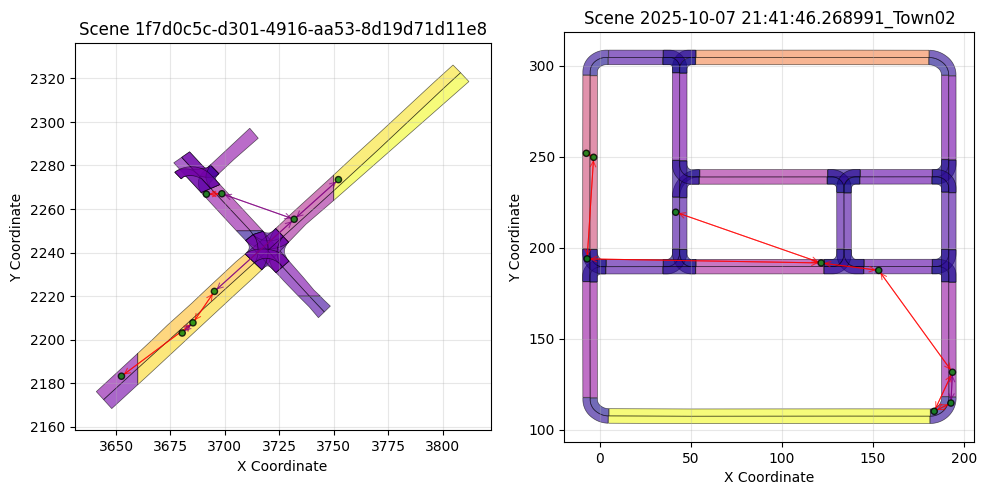

Error processing scene 2025-10-07 21:40:53.291456_Town01 and 2025-10-05 20:58:31.154340_Town01: [Errno 2] No such file or directory: '/home/tmuehlen/repos/graph_coverage/carla/data/scene_2025-10-05 20:58:31.154340_Town01_map_graph.pickle'


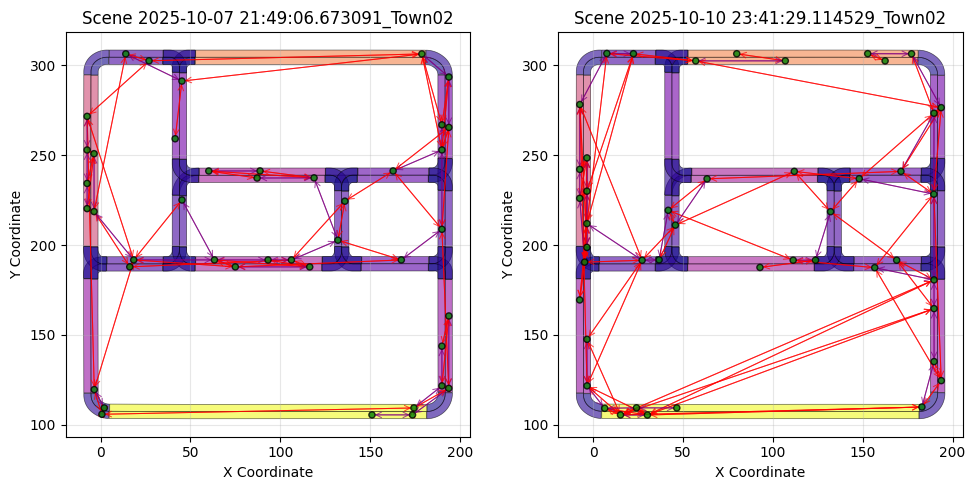

Error processing scene 2025-10-05 20:55:55.532439_Town01 and 2025-10-05 20:56:40.894877_Town01: [Errno 2] No such file or directory: '/home/tmuehlen/repos/graph_coverage/carla/data/scene_2025-10-05 20:56:40.894877_Town01_map_graph.pickle'


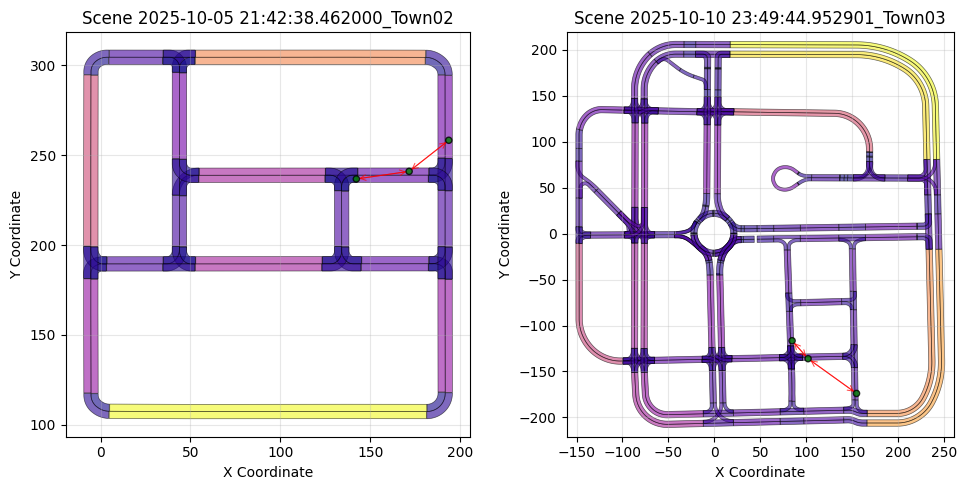

In [47]:
# comparing, no restrictions
for i in range(10):
    try:
        first = pca_emb_df.sample(1)
        pca_emb_df["sq_diff"] = ((pca_emb_df[list(range(256))] - first[list(range(256))].values)**2).sum(axis = 1)

        #pca_emb_df["dist"] = (pca_em.pca1 - first.pca1.iloc[0])**2 + (pca_carla_df.pca2 - first.pca2.iloc[0])**2 
        pca_emb_df.sort_values("sq_diff", inplace=True)

        if first.graph_type.iloc[0] == "carla_w_intersection":
            graph_1 = pca_emb_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            #scn_1 = graph_1[:26]
            scn_1 = "_".join(graph_1.split("_")[:2])

            file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_{graph_1}.pkl"
            with open(file_path_1, 'rb') as f:
                nx_graph_1 = pickle.load(f)
            g_map_1 = MapGraph()
            g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_1}_map_graph.pickle')
            g_map_1 = g_map_1.graph
        else:
            # argoverse option
            graph_1 = pca_emb_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_1 = graph_1[:36]
            file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/graph_{graph_1}.pkl"
            with open(file_path_1, 'rb') as f:
                nx_graph_1 = pickle.load(f)
            g_map_1 = MapGraph()
            # "/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/000ace8b-a3d2-4228-bd87-91b66a9c5127_map_graph.pkl"
            # g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_1}_map_graph.pkl')
            g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse/{scn_1}_map_graph.pkl')
            g_map_1 = g_map_1.graph.graph

        if pca_emb_df.graph_type.iloc[1] == "carla_w_intersection":
            graph_2 = pca_emb_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            # scn_2 = graph_2[:26]
            scn_2 = "_".join(graph_2.split("_")[:2])
            file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_{graph_2}.pkl"
            with open(file_path_2, 'rb') as f:
                nx_graph_2 = pickle.load(f)
            g_map_2 = MapGraph()
            g_map_2.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_2}_map_graph.pickle')
            g_map_2 = g_map_2.graph
        else:
            # argoverse option
            graph_2 = pca_emb_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_2 = graph_2[:36]
            file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/graph_{graph_2}.pkl"
            with open(file_path_2, 'rb') as f:
                nx_graph_2 = pickle.load(f)
            g_map_2 = MapGraph()
            # g_map_2.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_2}_map_graph.pkl')
            g_map_2.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse/{scn_2}_map_graph.pkl')
            g_map_2 = g_map_2.graph.graph

        # # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        # # First scene (left subplot)
        fig, ax1 = plot_lane_map_advanced(g_map_1, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # # Second scene (right subplot)
        fig, ax2 = plot_lane_map_advanced(g_map_2, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # # Adjust layout and display
        plt.tight_layout()
        plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_comparison_plausibility_check_{i}.png")
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


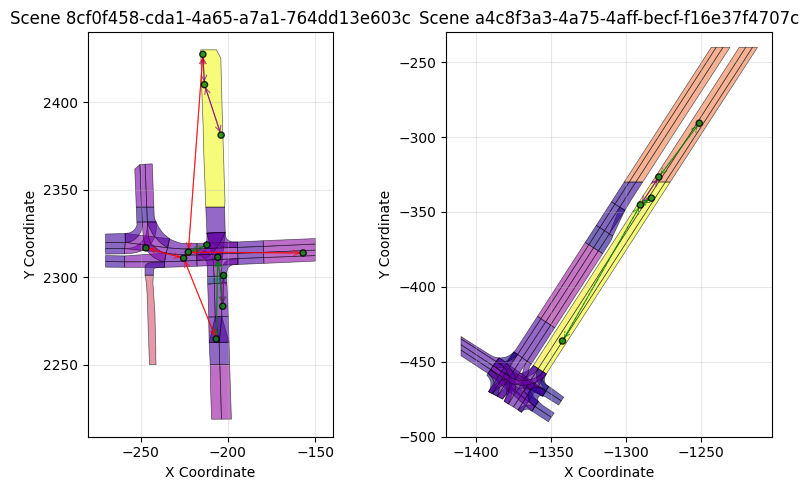

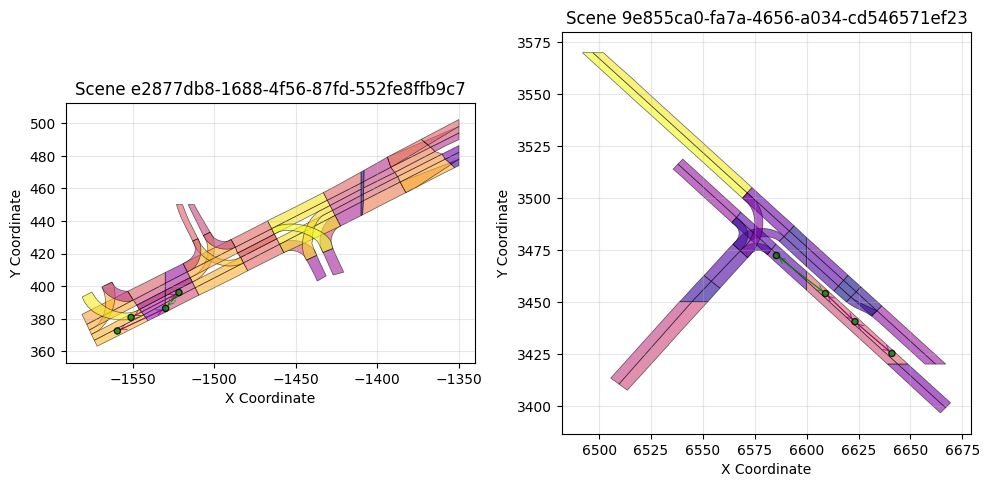

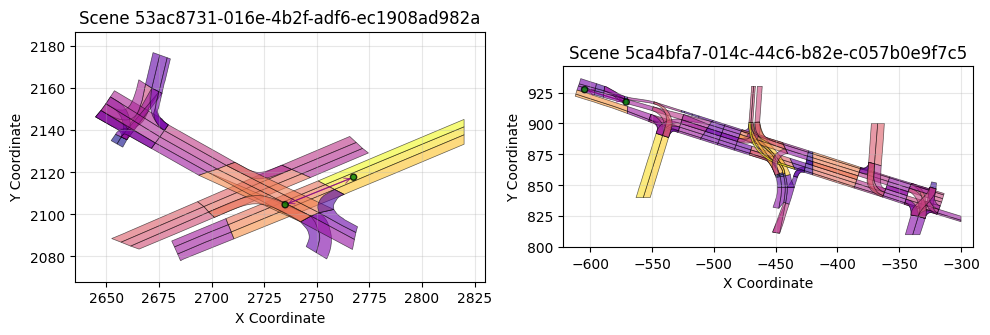

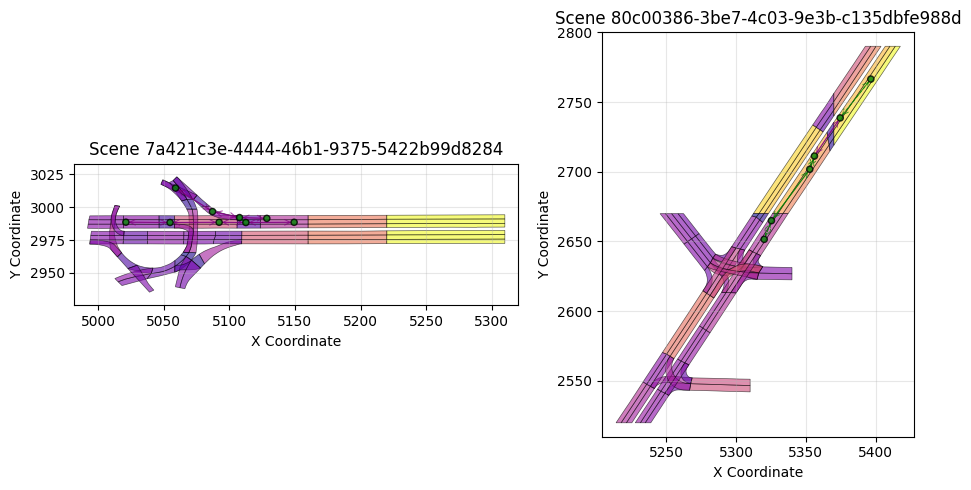

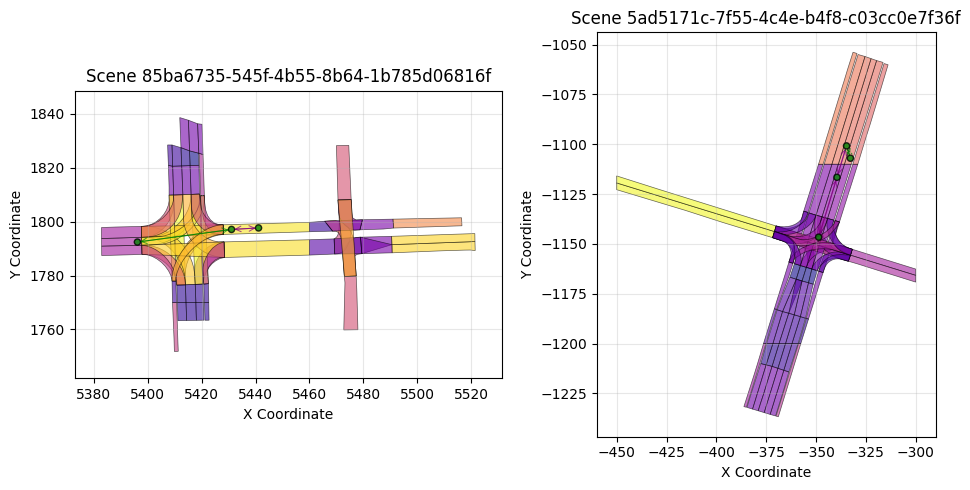

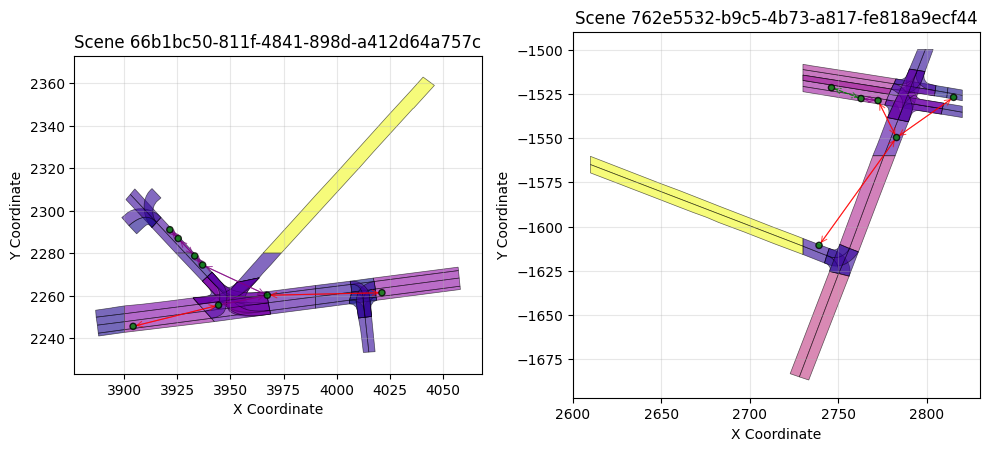

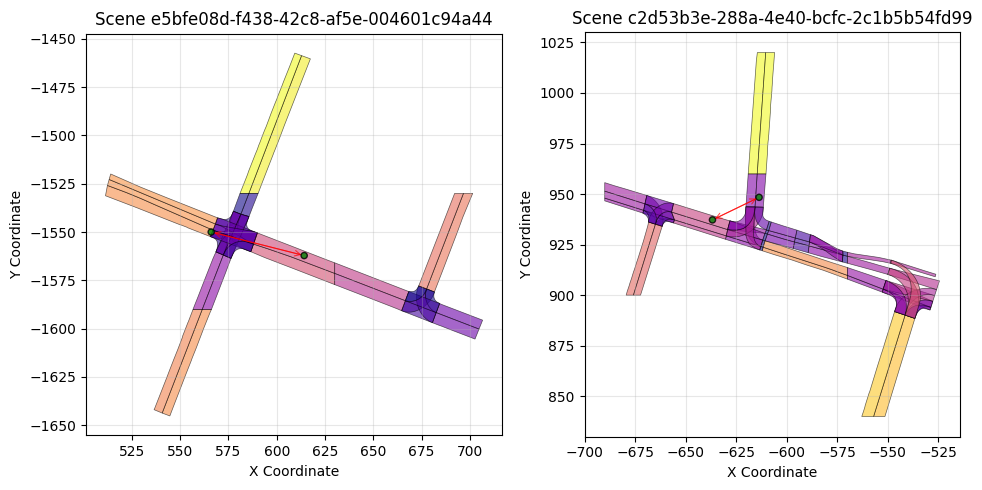

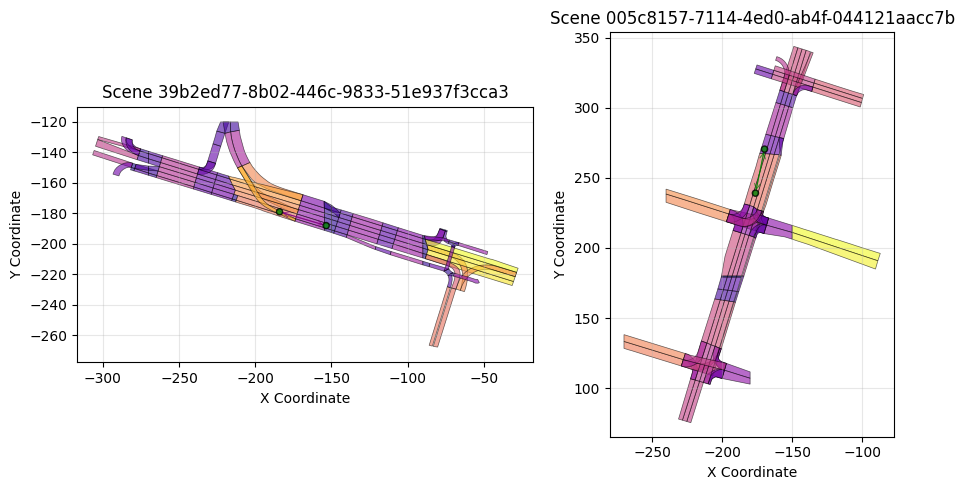

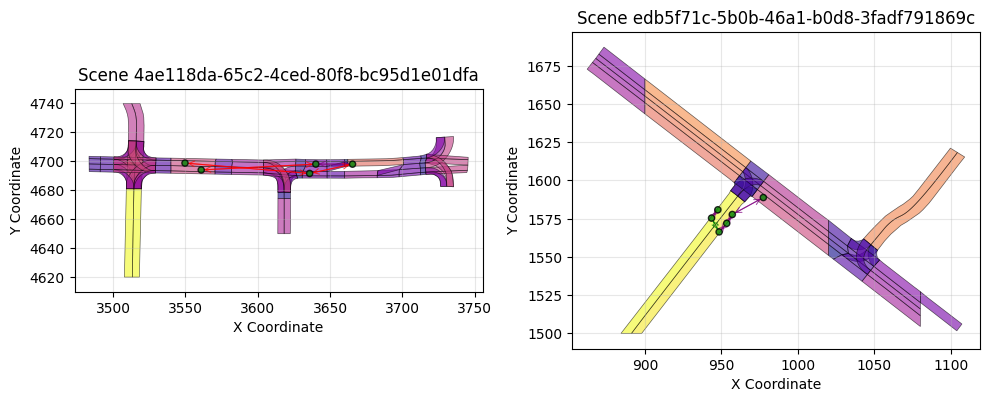

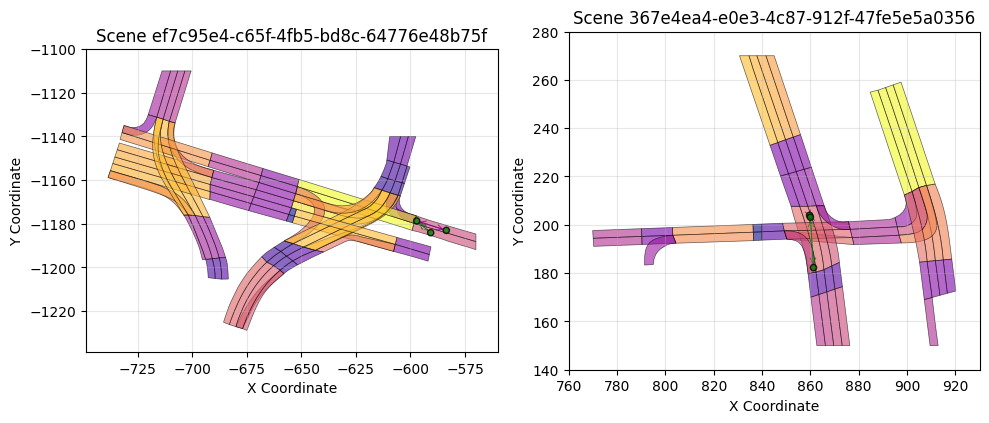

In [ ]:
# comparing argo to argo
# TODO: update this to use the actual embeddings for the distance calculation

for i in range(10):
    first = pca_argo_df.sample(1)
    pca_argo_df["dist"] = (pca_argo_df.pca1 - first.pca1.iloc[0])**2 + (pca_argo_df.pca2 - first.pca2.iloc[0])**2 
    pca_argo_df.sort_values("dist", inplace=True)
    graph_1 = pca_argo_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
    graph_2 = pca_argo_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
    scn_1 = graph_1[:36]
    scn_2 = graph_2[:36]
    file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/graph_{graph_1}.pkl"
    with open(file_path_1, 'rb') as f:
        nx_graph_1 = pickle.load(f)
    file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/graph_{graph_2}.pkl"
    with open(file_path_2, 'rb') as f:
        nx_graph_2 = pickle.load(f)
    # # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    # First scene (left subplot)
    g_map = MapGraph()
    # "/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/000ace8b-a3d2-4228-bd87-91b66a9c5127_map_graph.pkl"
    g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse/{scn_1}_map_graph.pkl')
    # g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_1}_map_graph.pkl')
    fig, ax1 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
    fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
    fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
    ax1.set_title(f'Scene {scn_1}')
    # Second scene (right subplot)
    g_map = MapGraph()
    g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse/{scn_2}_map_graph.pkl')
    # g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_2}_map_graph.pkl')
    fig, ax2 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
    fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
    fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
    ax2.set_title(f'Scene {scn_2}')
    # Adjust layout and display
    plt.tight_layout()
    plt.show()


2025-10-05 20:57:17.716974_Town01_Opt_9_1 2025-10-05 20:57:17.716974_Town01
2025-10-07 21:42:59.677431_Town03_14_4 2025-10-07 21:42:59.677431_Town03
Error processing scene 2025-10-05 20:57:17.716974_Town01 and 2025-10-07 21:42:59.677431_Town03: [Errno 2] No such file or directory: '/home/tmuehlen/repos/graph_coverage/carla/data/scene_2025-10-05 20:57:17.716974_Town01_map_graph.pickle'
2025-10-06 22:57:27.115859_Town04_11_2 2025-10-06 22:57:27.115859_Town04
2025-10-05 20:57:17.716974_Town01_Opt_4_1 2025-10-05 20:57:17.716974_Town01
Error processing scene 2025-10-06 22:57:27.115859_Town04 and 2025-10-05 20:57:17.716974_Town01: [Errno 2] No such file or directory: '/home/tmuehlen/repos/graph_coverage/carla/data/scene_2025-10-05 20:57:17.716974_Town01_map_graph.pickle'
2025-10-10 23:36:48.316943_Town04_3_2 2025-10-10 23:36:48.316943_Town04
2025-10-06 22:57:27.115859_Town04_14_3 2025-10-06 22:57:27.115859_Town04


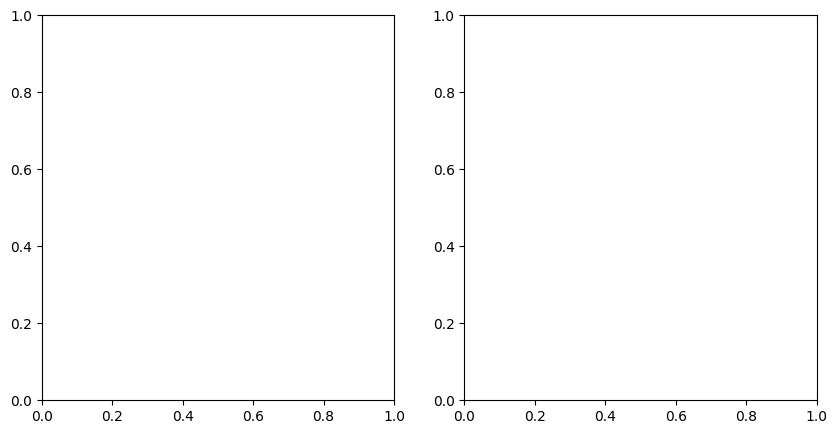

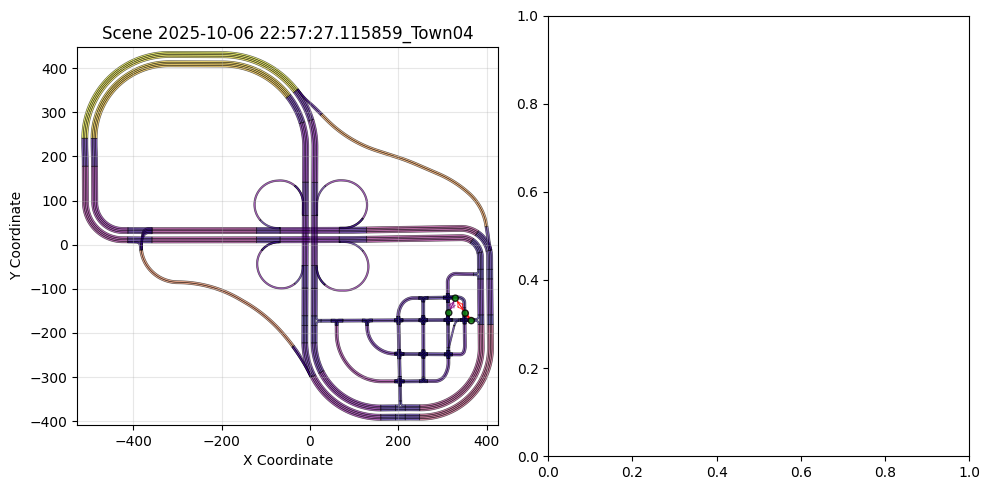

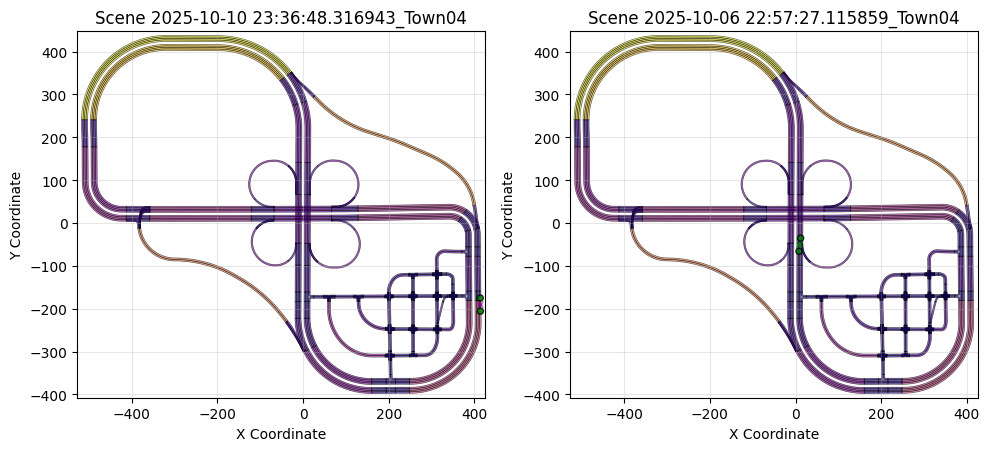

2025-10-05 20:55:55.532439_Town01_4_3 2025-10-05 20:55:55.532439_Town01
2025-10-07 20:57:23.937078_Town03_11_9 2025-10-07 20:57:23.937078_Town03


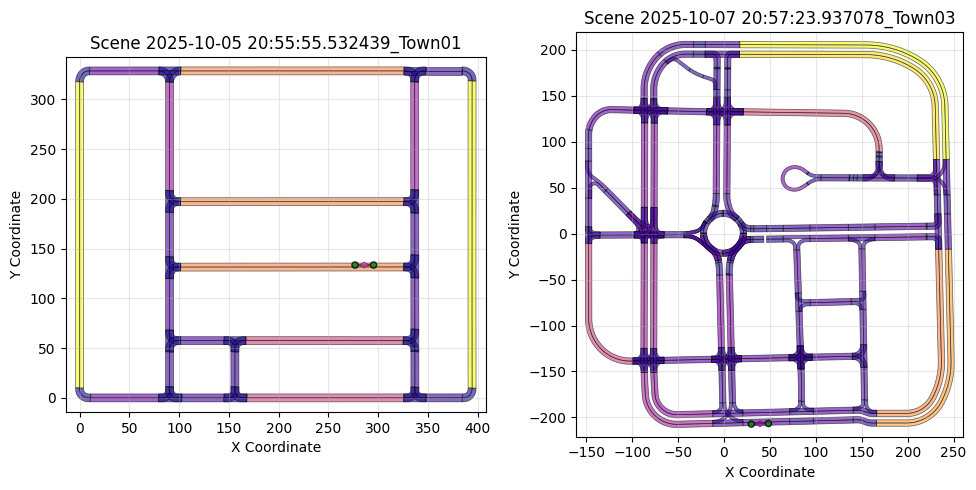

2025-10-06 22:44:01.637433_Town05_5_1 2025-10-06 22:44:01.637433_Town05
2025-10-10 23:38:00.637659_Town05_0_6 2025-10-10 23:38:00.637659_Town05


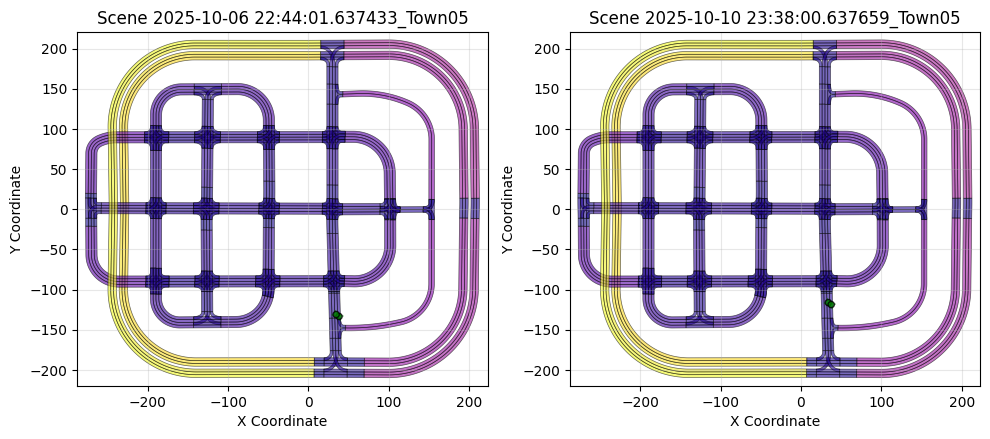

2025-10-07 20:55:40.190957_Town02_0_2 2025-10-07 20:55:40.190957_Town02
2025-10-05 21:48:33.493801_Town04_14_3 2025-10-05 21:48:33.493801_Town04


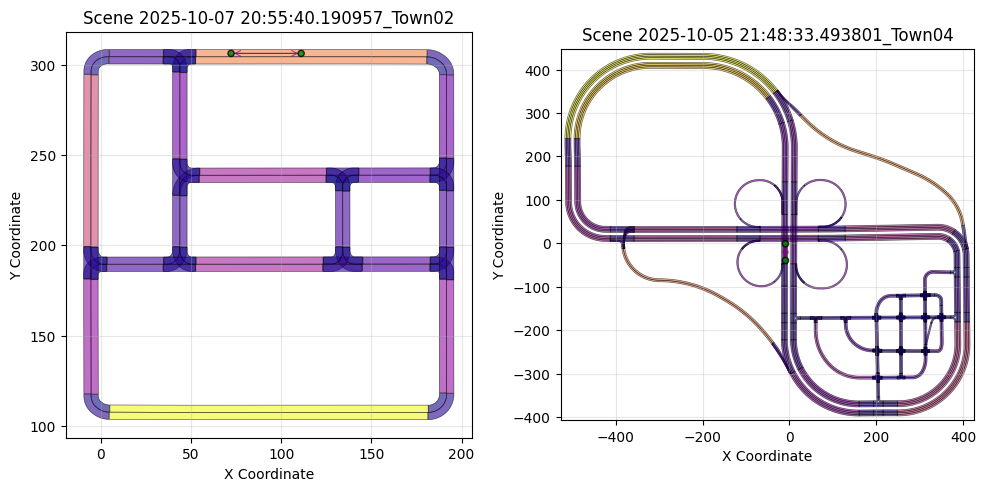

2025-10-10 23:47:37.793421_Town01_0_5 2025-10-10 23:47:37.793421_Town01
2025-10-10 23:33:14.429480_Town01_9_8 2025-10-10 23:33:14.429480_Town01


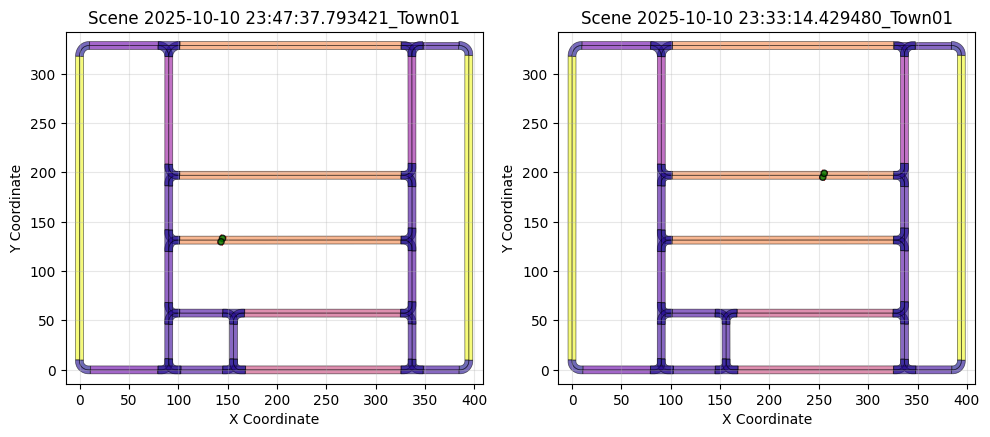

2025-10-05 21:46:51.867040_Town03_13_0 2025-10-05 21:46:51.867040_Town03
2025-10-10 23:40:30.667597_Town01_11_6 2025-10-10 23:40:30.667597_Town01


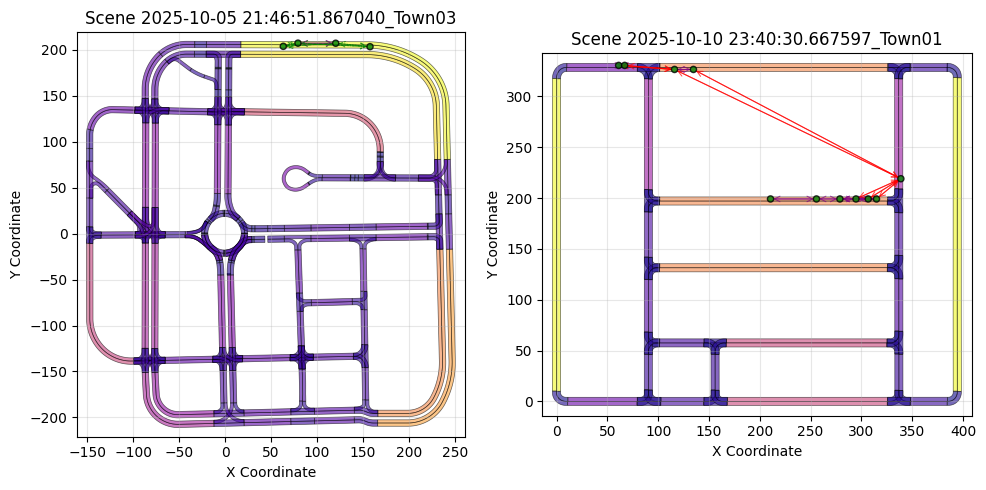

2025-10-05 21:28:36.127587_Town05_14_2 2025-10-05 21:28:36.127587_Town05
2025-10-11 00:00:41.720895_Town05_10_4 2025-10-11 00:00:41.720895_Town05


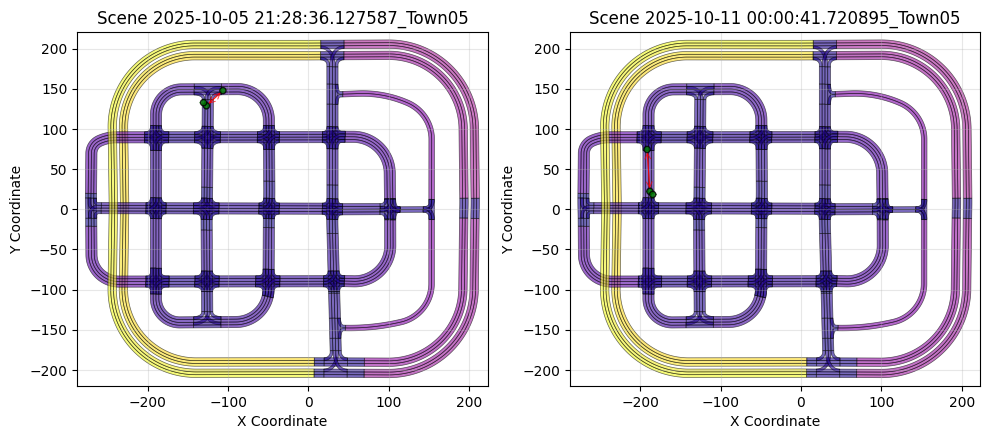

2025-10-10 23:40:30.667597_Town01_11_6 2025-10-10 23:40:30.667597_Town01
2025-10-10 23:33:14.429480_Town01_3_7 2025-10-10 23:33:14.429480_Town01


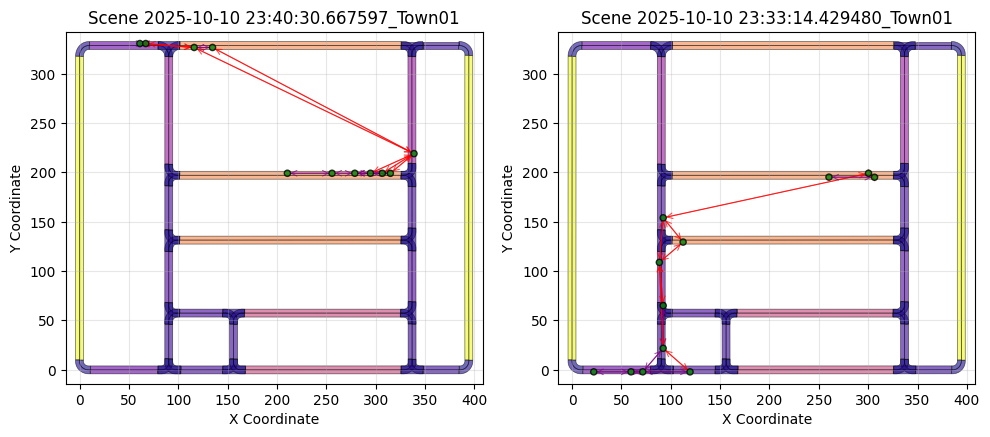

In [ ]:
# TODO: update this to use the actual embeddings for the distance calculation
# comparing carla to carla

for i in range(10):
    try:
        first = pca_carla_df.sample(1)
        pca_carla_df["dist"] = (pca_carla_df.pca1 - first.pca1.iloc[0])**2 + (pca_carla_df.pca2 - first.pca2.iloc[0])**2 
        pca_carla_df.sort_values("dist", inplace=True)
        #print(pca_df.graph_path.iloc[0])
        #print(pca_df.graph_path.iloc[1])
        graph_1 = pca_carla_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        graph_2 = pca_carla_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn_1 = "_".join(graph_1.split("_")[:2])
        scn_2 = "_".join(graph_2.split("_")[:2])
        print(graph_1, scn_1)
        print(graph_2, scn_2)
        pca_df.head(2)
        file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_{graph_1}.pkl"
        with open(file_path_1, 'rb') as f:
            nx_graph_1 = pickle.load(f)
        file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_{graph_2}.pkl"
        with open(file_path_2, 'rb') as f:
            nx_graph_2 = pickle.load(f)
        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_1}_map_graph.pickle')
        fig, ax1 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # Second scene (right subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_2}_map_graph.pickle')
        fig, ax2 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # Adjust layout and display
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


# Plotting a random selection of graphs from the selection dataframe:

# Notebook junkyard